```{eval-rst}
.. include:: sinebow.rst

```

{sinebow22}`Cell diameter`
==================================

The idea of an average cell diameter sounds intuitive, but the standard implementation of this idea fails to capture that intuition. 
The go-to method (adopted in Cellpose) is to calculate the cell diameter as the diameter of the circle of equivalent area. As I will demonstrate, 
this fails for anisotropic (non-circular) cells. As an alternative, I devised the following simple diameter metric: 

```python
diameter = 2*(dimension+1)*np.mean(distance_field)
```

Because the distance field represents the distance to the *closest* boundary point, it naturally captures the intrinsic 'thickness' of a region (in any dimension). Averaging the field over the region 
(the first moment of the distribution) distills this information into a number that is intuitively proportional to the thickness of the region. For example, if a region is made up of a bungle of many 
thin fragments, its mean distance is far smaller than the mean distance of the circle of equivalent area. But to call it a 'diameter', I wanted this metric to match the diameter of a sphere in any dimension. 
So, by calculating the average of distance field of an n-sphere, we get the above expression for the the diameter of an n-sphere given the average of the distance field over the volume. 

## Example cells

Filamenting bacterial cells often exhibit constant width but increasing length. This dataset comes from the deletion of the essential gene *ftsN* in *Acinetobacter baylyi*. 

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


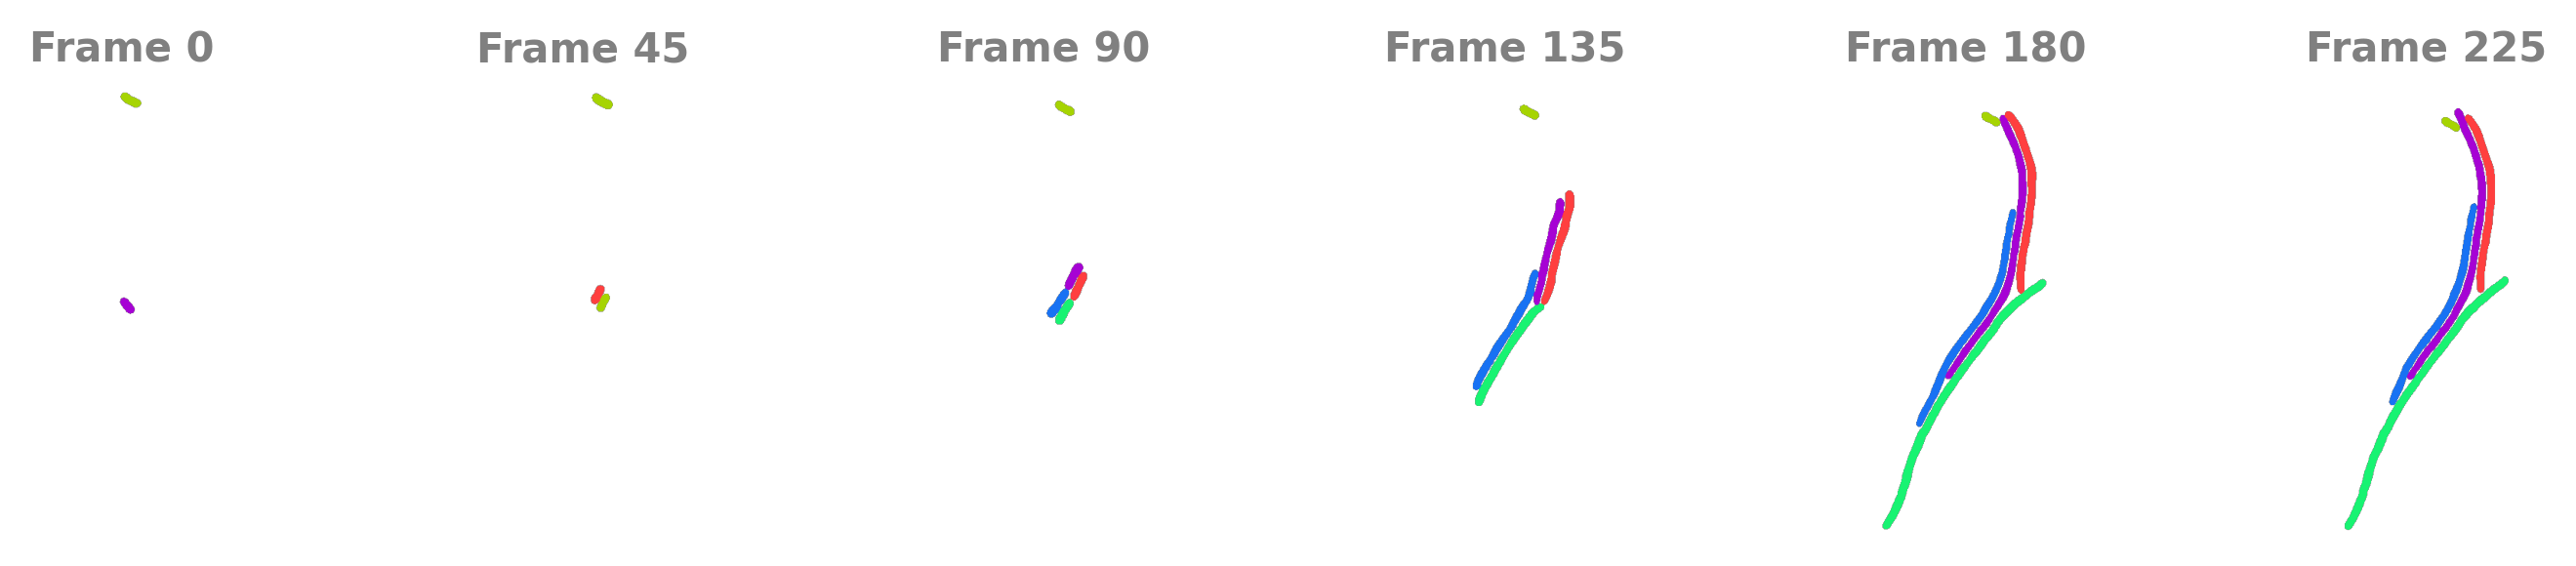

In [ ]:
from pathlib import Path
from cellpose_omni import utils, plot, models, io, dynamics
import os, sys, io
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Save a reference to the original stdout stream
old_stdout = sys.stdout

# Redirect stdout to a StringIO object
sys.stdout = io.StringIO()


import omnipose
from omnipose.plot import imshow
import tifffile
omnidir = Path(omnipose.__file__).parent.parent
basedir = os.path.join(omnidir,'docs','_static')
nm = 'ftsZ'
masks = tifffile.imread(os.path.join(basedir,nm+'_masks.tif'))
mnc = omnipose.plot.apply_ncolor(masks)

f = 1
c = [0.5]*3
fontsize=10
dpi = mpl.rcParams['figure.dpi']
Y,X = masks.shape[-2:]
szX = max(X//dpi,2)*f
szY = max(Y//dpi,2)*f

# T = [50,80,100,150,180,240]
T = range(0,len(masks),45)
titles = ['Frame {}'.format(t) for t in T]
ims = [mnc[t] for t in T]
N = len(titles)

fig, axes = plt.subplots(1,N, figsize=(szX*N,szY))  
fig.patch.set_facecolor([0]*4)

for i,ax in enumerate(axes):
    ax.imshow(ims[i])
    ax.axis('off')
    ax.set_title(titles[i],c=c,fontsize=fontsize,fontweight="bold")

plt.subplots_adjust(wspace=0.1)
plt.show()

# Restore the original stdout stream
sys.stdout = old_stdout

## Compare diameter metrics
By plotting the mean diameter (averaged over all cells after being computed per-cell, of course), we find that 
the 'circle diameter metric' used in Cellpose rises drastically with cell length, but the 'distance diameter metric' of Omnipose remains nearly constant. If we tried to use the former to train a `SizeModel()`, images would get downsampled 
heavily to the point of cells being **too thin to segment**, and that is assuming that the model can reliably detect the highly nonlocal property of cell length in an image instead of the local property of 
cell width (at least, what we humans would point to and *call* cell width). 

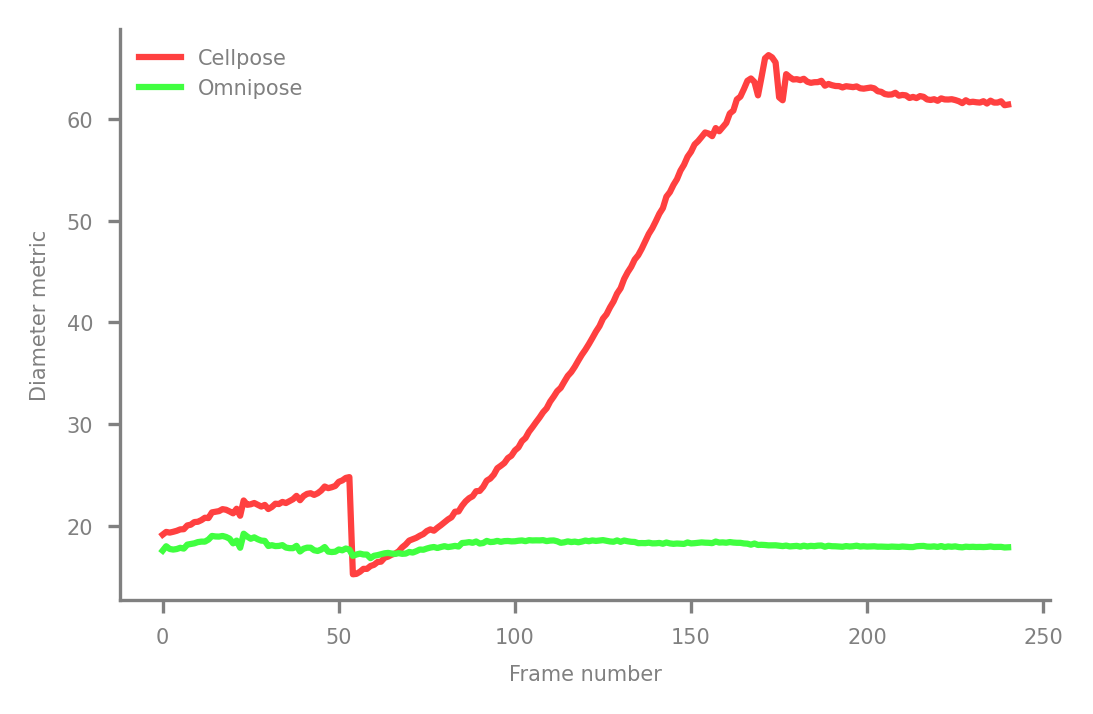

In [ ]:
import fastremap
n = len(masks)
diam_old = []
diam_new = []
cell_num = []
x = range(n)
for k in x:
    m = masks[k]
    fastremap.renumber(m,in_place=True)
    cell_num.append(m.max())
    diam_old.append(utils.diameters(m,omni=False)[0])
    diam_new.append(utils.diameters(m,omni=True)[0])


from omnipose.utils import sinebow
golden = (1 + 5 ** 0.5) / 2
sz = 4
labelsize = 5

%matplotlib inline

plt.style.use('dark_background')
mpl.rcParams['figure.dpi'] = 300 

axcol = [0.5]*3+[1]
N = 3
colors = sinebow(N,offset=0)
background_color = [0]*4

fig = plt.figure(figsize=(sz, sz/golden)) 
fig.patch.set_facecolor([0]*4)

ax = plt.axes()

ax.plot(range(n),diam_old,c=colors[1],label='Cellpose')
ax.plot(range(n),diam_new,c=colors[N],label='Omnipose')

ax.legend(loc='best', frameon=False,labelcolor=axcol, fontsize = labelsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.set_ylabel('Diameter metric', fontsize = labelsize,c=axcol)
ax.set_xlabel('Frame number', fontsize = labelsize, c=axcol)
ax.set_facecolor(background_color)

for spine in ax.spines.values():
    spine.set_color(axcol)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()